# Some part of this code was taken from here: https://github.com/ultralytics/ultralytics/issues/4827

In [1]:
# !pip install tensorflow[and-cuda]
# !pip install opencv-python
# !pip install matplotlib

In [2]:
import numpy as np
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt
import glob

2024-02-05 16:03:58.940709: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 16:03:58.990594: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 16:03:58.991463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 16:03:59.757977: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
confidence_threshold=0.5
iou_threshold=0.5

In [4]:
CLASSES=['drone']

In [5]:
IMG_FOLDER=glob.glob('./images/*')
MODEL_PATH="./best_float16.tflite"

In [6]:
def predict_and_show(model_path, img_names):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    image_height = input_details[0]['shape'][1] 
    image_width = input_details[0]['shape'][2]

    for img_name in img_names:
        image=cv2.imread(img_name)
        
        resized_image= cv2.resize(image, (image_width, image_height))
        input_image = np.array(resized_image) #
        input_image = np.true_divide(input_image, 255, dtype=np.float32) 
        input_image = input_image[np.newaxis, :]
        
        interpreter.set_tensor(input_details[0]['index'], input_image)
        interpreter.invoke()

        output = interpreter.get_tensor(output_details[0]['index'])
        output = output[0]
        output = output.T

        boxes_xywh = output[..., :4] 
        scores = np.max(output[..., 4:], axis=1)
        classes = np.argmax(output[..., 4:], axis=1)

        indices = cv2.dnn.NMSBoxes(boxes_xywh, scores, confidence_threshold, iou_threshold)

        threshold = 0.25

        for i in indices:
            if scores[i] >= threshold:
                x_center, y_center, width, height = boxes_xywh[i]
                
                x1 = int((x_center - width / 2) * image_width)
                y1 = int((y_center - height / 2) * image_height)
                x2 = int((x_center + width / 2) * image_width)
                y2 = int((y_center + height / 2) * image_height)

                image_with_box = cv2.rectangle(resized_image, (x1,y1), (x2,y2), [0,0,255], 1)
                cv2.putText(image_with_box, f'{CLASSES[classes[i]]}:{scores[i]:.2f}',(x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        
        
        try:
            plt.imshow(cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB))
        except: 
            print('*** THE MODEL DID NOT DETECT A SINGLE OBJECT IN: ', img_name)
            plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
        plt.show()

        

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


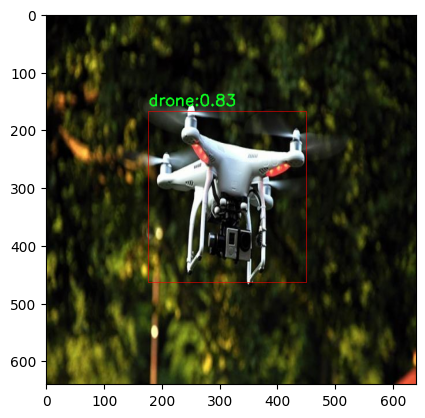

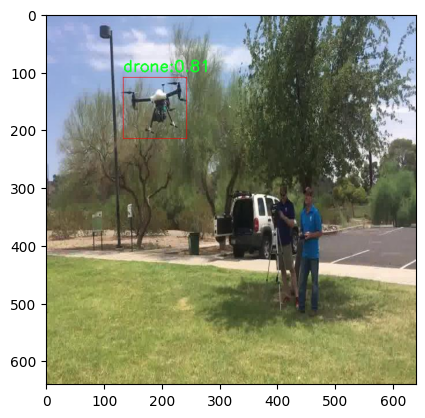

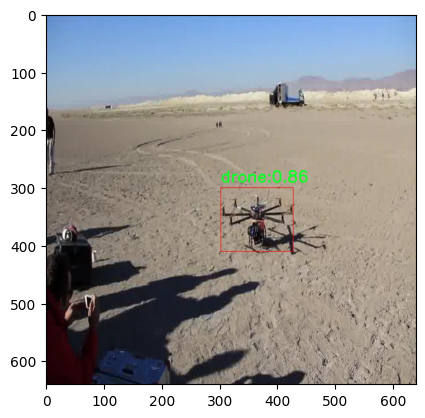

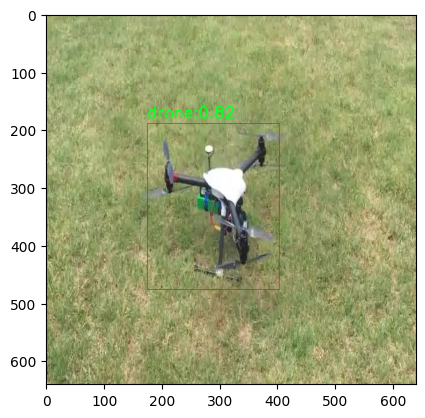

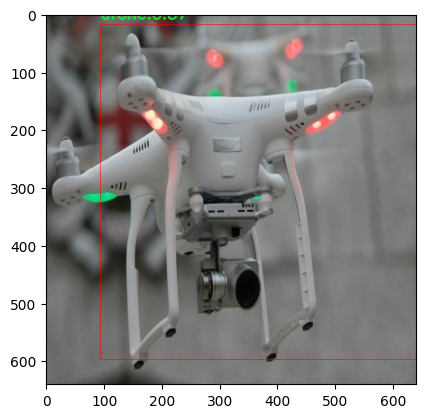

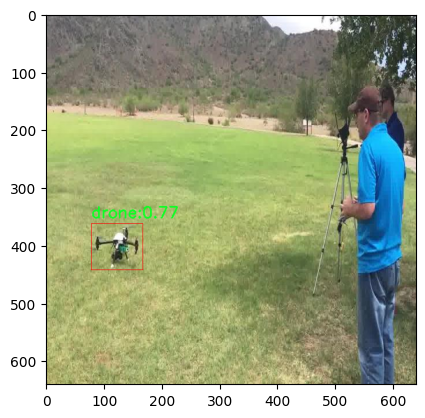

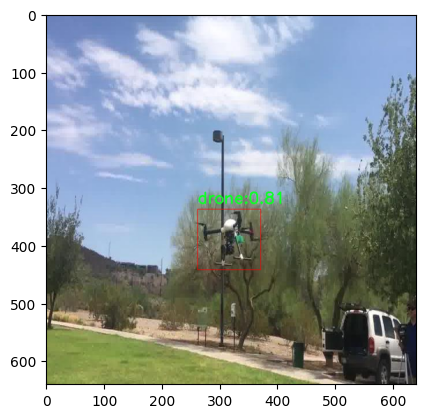

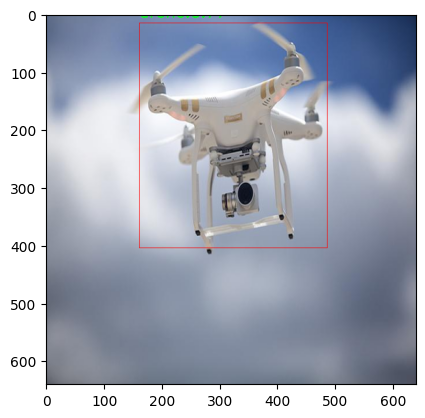

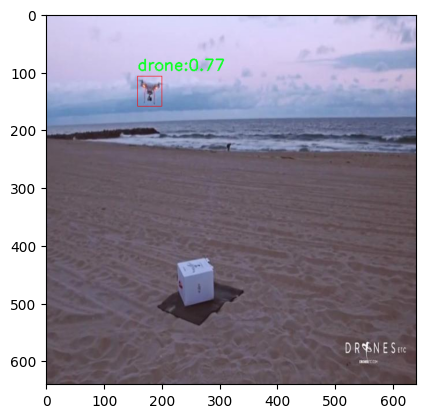

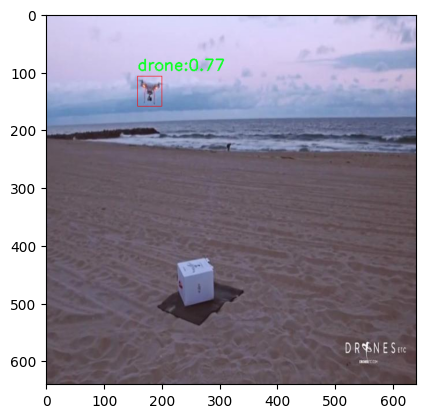

In [7]:
predict_and_show(MODEL_PATH, IMG_FOLDER[:10])